In [1]:
import sys
sys.path.append('../')
from src.models.linear_regression.closed_form import linear_regression_closed_form
from src.models.linear_regression.gradient_descent_base import linear_regression_gradient_descent
from src.models.linear_regression.lasso_gradient_descent import linear_regression_gradient_descent_lasso
from src.models.linear_regression.ridge_gradient_descent import linear_regression_gradient_descent_ridge
from src.utils.split_data import split_train_val_test 
from src.utils.metrics import mean_squared_error_2, mean_absolute_error_2
#####################################################################################################
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#####################################################################################################
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PowerTransformer, StandardScaler



In [2]:
df=pd.read_csv('../data/raw/California_Houses.csv')
df

,Median_House_Value,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
0,452600.0,8.3252,41,880,129,322,126,37.88,-122.23,9263.040773,556529.158342,735501.806984,67432.517001,21250.213767
1,358500.0,8.3014,21,7099,1106,2401,1138,37.86,-122.22,10225.733072,554279.850069,733236.884360,65049.908574,20880.600400
2,352100.0,7.2574,52,1467,190,496,177,37.85,-122.24,8259.085109,554610.717069,733525.682937,64867.289833,18811.487450
3,341300.0,5.6431,52,1274,235,558,219,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568
4,342200.0,3.8462,52,1627,280,565,259,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,78100.0,1.5603,25,1665,374,845,330,39.48,-121.09,162031.481121,654530.186299,830631.543047,248510.058162,222619.890417
20636,77100.0,2.5568,18,697,150,356,114,39.49,-121.21,160445.433537,659747.068444,836245.915229,246849.888948,218314.424634
20637,92300.0,1.7000,17,2254,485,1007,433,39.43,-121.22,153754.341182,654042.214020,830699.573163,240172.220489,212097.936232
20638,84700.0,1.8672,18,1860,409,741,349,39.43,-121.32,152005.022239,657698.007703,834672.461887,238193.865909,207923.199166


In [3]:
y=df['Median_House_Value']
df=df.drop(columns=['Median_House_Value'])
from sklearn.model_selection import train_test_split

# Step 1: Split into train + temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    df, y, train_size=0.7, random_state=42
)

# Step 2: Split temp into validation and test
val_ratio = 0.15 / (0.15 + 0.15)  # proportion of temp to be validation
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, train_size=val_ratio, random_state=42
)

# Check shapes
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (14447, 13) (14447,)
Validation: (3096, 13) (3096,)
Test: (3097, 13) (3097,)


In [4]:
X_train.shape

(14447, 13)

In [5]:
X_test.shape

(3097, 13)

In [6]:
X_val.shape

(3096, 13)

# Preprocessing

In [7]:
from sklearn.preprocessing import PowerTransformer, StandardScaler
import pandas as pd

cols_to_power = [
    'Distance_to_coast',
    'Median_Income',
    'Tot_Rooms',
    'Tot_Bedrooms',
    'Population',
    'Households'
]

pt = PowerTransformer(method='yeo-johnson')
X_train_pt = X_train.copy()
#X_train_pt[cols_to_power] = pt.fit_transform(X_train[cols_to_power])

X_val_pt = X_val.copy()
#X_val_pt[cols_to_power] = pt.transform(X_val[cols_to_power])

X_test_pt = X_test.copy()
#X_test_pt[cols_to_power] = pt.transform(X_test[cols_to_power])
#########################################
from sklearn.preprocessing import RobustScaler

scaler = StandardScaler()

# Fit on training data and transform
X_train_scaled = X_train_pt.copy()
X_train_scaled[X_train_scaled.columns] = scaler.fit_transform(X_train_pt)

# Transform validation and test
X_val_scaled = X_val_pt.copy()
X_val_scaled[X_val_scaled.columns] = scaler.transform(X_val_pt)

X_test_scaled = X_test_pt.copy()
X_test_scaled[X_test_scaled.columns] = scaler.transform(X_test_pt)



from sklearn.preprocessing import StandardScaler
import pandas as pd

# Initialize the scaler
y_scaler = StandardScaler()

# Fit on training targets and transform all splits
y_train = pd.Series(
    y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten(),
    index=y_train.index,
    name=y_train.name
)

y_val = pd.Series(
    y_scaler.transform(y_val.values.reshape(-1, 1)).flatten(),
    index=y_val.index,
    name=y_val.name
)

y_test = pd.Series(
    y_scaler.transform(y_test.values.reshape(-1, 1)).flatten(),
    index=y_test.index,
    name=y_test.name
)






In [8]:
y_train

14689   -0.321599
17323    0.456808
10056   -0.611882
15750    2.531993
15283    0.642554
           ...   
11284    0.192443
11964   -0.942770
5390     0.131104
860      0.661561
15795    1.020095
Name: Median_House_Value, Length: 14447, dtype: float64

In [9]:
X_train_scaled

,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
14689,-0.532191,-0.679820,-0.213567,-0.013907,-0.376191,-0.013283,-1.339512,1.245307,-0.537569,-0.379179,-1.348102,1.479798,1.407224
17323,0.170993,-0.362700,-0.482631,-0.614215,-0.611232,-0.565320,-0.496695,-0.277494,-0.566721,-0.348598,-0.190173,-0.018144,0.098570
10056,-0.402893,-1.155500,-0.848318,-0.926279,-0.987474,-0.949915,1.689948,-0.706874,2.045942,1.442594,1.398734,-0.553215,-0.712687
15750,-0.299266,1.857140,0.251054,0.400590,0.085999,0.426254,0.992282,-1.430829,-0.765389,1.167037,1.169631,-1.286707,-1.534766
15283,0.106161,-1.393341,3.827018,3.576025,2.933685,3.550106,-1.161584,1.125480,-0.669644,-0.568332,-1.201847,1.263900,1.219988
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,1.308791,0.509380,-0.607917,-0.807170,-0.675255,-0.743228,-0.875963,0.810934,-0.567661,-0.928773,-0.901775,0.850524,0.861318
11964,-0.434076,0.350820,0.202974,0.071851,0.285083,-0.136249,-0.763587,1.075552,0.450754,-0.787688,-0.876077,0.916974,0.918148
5390,-0.494761,0.588660,-0.251476,0.069469,0.287714,0.067822,-0.758905,0.601237,-0.591024,-1.038356,-0.745832,0.636838,0.675763
860,0.967147,-1.076220,0.429968,0.136169,0.306131,0.151543,0.903318,-1.186182,-0.547446,0.986783,1.016500,-1.476299,-1.354291


In [10]:
X_val_scaled

,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
13259,-0.548202,-1.393341,2.194603,2.992393,2.116302,2.930045,-0.726128,0.950732,0.308245,-0.879786,-0.827268,0.812081,0.827467
14100,-1.220623,0.192260,-0.651836,-0.364087,-0.536686,-0.272296,-1.353559,1.245307,-0.587632,-0.368411,-1.356152,1.491699,1.417524
7528,-0.894256,0.430100,-0.917202,-0.938190,-0.601585,-0.936834,-0.815093,0.676129,-0.501801,-1.026017,-0.811547,0.725068,0.752353
4015,2.384749,-0.600540,0.559877,0.017061,-0.005211,0.088752,-0.702717,0.501381,-0.566874,-0.957763,-0.669911,0.535204,0.587452
10182,0.699785,0.509380,-0.077185,-0.259271,-0.083266,-0.193807,-0.838504,0.815927,-0.432729,-0.950974,-0.877143,0.822432,0.836973
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17554,-1.261938,0.509380,0.302833,1.463039,1.483970,1.501550,0.786260,-1.146240,-0.350301,0.884909,0.927820,-1.598758,-1.264050
1498,1.949137,-0.283420,0.003256,-0.487959,-0.320939,-0.437122,1.067199,-1.211146,-0.526233,1.117533,1.130030,-1.295850,-1.377904
16657,-0.075161,-0.917660,0.034231,0.117112,-0.036784,0.180323,-0.178297,-0.537119,-0.560804,-0.046456,0.100640,-0.427996,-0.258545
12725,-0.576445,-0.124860,0.580219,0.562578,0.106171,0.680034,1.385597,-0.881622,0.456405,1.237445,1.230440,-0.914486,-1.010527


In [11]:
X_test_scaled

,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
1853,-0.681069,-0.91766,0.377265,0.433941,0.455225,0.381777,2.865210,-2.309560,-0.758091,2.954591,2.705890,0.849557,0.339727
584,0.833125,0.50938,-0.200622,-0.452227,-0.371806,-0.356017,0.964188,-1.246095,-0.594309,1.058551,1.078229,-1.397963,-1.414594
12228,-0.790419,-1.15550,-0.168260,-0.271182,-0.468278,-0.185958,-0.894692,1.340170,0.638024,-0.571397,-0.982222,1.179962,1.145886
2457,-0.390347,0.11298,-0.450269,-0.526074,-0.405133,-0.573169,0.402310,-0.032847,2.523107,0.124462,0.272345,-0.591282,-0.404768
10228,-0.278058,1.30218,-0.757705,-0.738087,-0.167460,-0.690902,-0.833822,0.825913,-0.391469,-0.947691,-0.876973,0.824265,0.838565
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107,-0.148970,-0.83838,0.005568,-0.104430,-0.001703,-0.047295,-0.014416,0.940747,3.089798,-0.360167,-0.255424,0.337184,0.401408
16868,-0.691306,0.58866,-0.404500,-0.097283,-0.177984,-0.110086,0.912683,-1.400872,-0.697779,1.097669,1.109075,-1.360935,-1.462729
15840,0.038388,1.85714,0.145648,0.198106,-0.207803,0.230032,0.982918,-1.420843,-0.755347,1.155675,1.159853,-1.299687,-1.530897
12181,-0.939192,-0.99694,0.106814,0.086144,0.378047,0.114915,-0.880645,1.155437,0.277888,-0.706714,-0.978031,1.055397,1.038562


# Modeling

## Baseline models 

### MODEL 1: MY CLOSED_FORM (all features)

In [12]:
model1_my_closed_form= linear_regression_closed_form()
model1_my_closed_form.fit(X_train_scaled,y_train)


In [13]:
pred_train_model1=model1_my_closed_form.predict(X_train_scaled)
pred_val_model1=model1_my_closed_form.predict(X_val_scaled)
pred_test_model1=model1_my_closed_form.predict(X_test_scaled)

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("################## TRAIN #####################")
print("MAE:", mean_absolute_error(y_train, pred_train_model1))
print("MSE:", mean_squared_error(y_train, pred_train_model1))

print("\n################## VALIDATION #####################")
print("MAE:", mean_absolute_error(y_val, pred_val_model1))
print("MSE:", mean_squared_error(y_val, pred_val_model1))

print("\n################## TEST #####################")
print("MAE:", mean_absolute_error(y_test, pred_test_model1))
print("MSE:", mean_squared_error(y_test, pred_test_model1))


################## TRAIN #####################
MAE: 0.43135197872996545
MSE: 0.35308617353839067

################## VALIDATION #####################
MAE: 0.43432534628737046
MSE: 0.35847400375001187

################## TEST #####################
MAE: 0.4258827499411596
MSE: 0.33619482428631736


### MODEL 2: MY CLOSED_FORM (dropped features)

In [15]:
cols_to_drop = [
     'Tot_Bedrooms', 'Tot_Rooms', 'Distance_to_LA', 'Distance_to_SanDiego', 'Distance_to_SanJose', 'Distance_to_SanFrancisco','Longitude'
]

# Drop from scaled DataFrames
X_train_scaled_droped = X_train_scaled.drop(columns=cols_to_drop)
X_val_scaled_droped = X_val_scaled.drop(columns=cols_to_drop)
X_test_scaled_droped = X_test_scaled.drop(columns=cols_to_drop)




In [16]:
model2_my_closed_form= linear_regression_closed_form()
model2_my_closed_form.fit(X_train_scaled_droped,y_train)

In [17]:
pred_train_model2=model2_my_closed_form.predict(X_train_scaled_droped)
pred_val_model2=model2_my_closed_form.predict(X_val_scaled_droped)
pred_test_model2=model2_my_closed_form.predict(X_test_scaled_droped)

In [18]:
print("################## TRAIN #####################")
print("MAE:", mean_absolute_error_2(y_train, pred_train_model2))
print("MSE:", mean_squared_error_2(y_train, pred_train_model2))
print("\n################## VALIDATION #####################")
print("MAE:", mean_absolute_error_2(y_val, pred_val_model2))
print("MSE:", mean_squared_error_2(y_val, pred_val_model2))
print("\n################## TEST #####################")
print("MAE:", mean_absolute_error_2(y_test, pred_test_model2))
print("MSE:", mean_squared_error_2(y_test, pred_test_model2))


################## TRAIN #####################
MAE: 0.4535244208676197
MSE: 0.3799553306417799

################## VALIDATION #####################
MAE: 0.4604958515988646
MSE: 0.38732752999613873

################## TEST #####################
MAE: 0.4473494316063303
MSE: 0.3632709423920469


### MODEL 3: SKLEARN CLOSED_FORM (all features)

In [19]:
from sklearn.linear_model import LinearRegression

# Initialize sklearn linear regression (no regularization)
model3_sklearn_closed_form = LinearRegression()

# Fit on training data
model3_sklearn_closed_form.fit(X_train_scaled, y_train)

# Make predictions
pred_train_model3 = model3_sklearn_closed_form.predict(X_train_scaled)
pred_val_model3 = model3_sklearn_closed_form.predict(X_val_scaled)
pred_test_model3 = model3_sklearn_closed_form.predict(X_test_scaled)

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("################## TRAIN #####################")
print("MAE:", mean_absolute_error(y_train, pred_train_model3))
print("MSE:", mean_squared_error(y_train, pred_train_model3))

print("\n################## VALIDATION #####################")
print("MAE:", mean_absolute_error(y_val, pred_val_model3))
print("MSE:", mean_squared_error(y_val, pred_val_model3))

print("\n################## TEST #####################")
print("MAE:", mean_absolute_error(y_test, pred_test_model3))
print("MSE:", mean_squared_error(y_test, pred_test_model3))


################## TRAIN #####################
MAE: 0.4313519787299654
MSE: 0.35308617353839067

################## VALIDATION #####################
MAE: 0.4343253462873706
MSE: 0.35847400375001215

################## TEST #####################
MAE: 0.42588274994115977
MSE: 0.3361948242863175


### MODEL 4: SKLEARN CLOSED_FORM (dropped features)

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize sklearn linear regression (closed-form)
model4_sklearn_closed_form = LinearRegression()

# Fit on training data with dropped columns
model4_sklearn_closed_form.fit(X_train_scaled_droped, y_train)

# Make predictions
pred_train_model4 = model4_sklearn_closed_form.predict(X_train_scaled_droped)
pred_val_model4 = model4_sklearn_closed_form.predict(X_val_scaled_droped)
pred_test_model4 = model4_sklearn_closed_form.predict(X_test_scaled_droped)

# Evaluate
print("################## TRAIN #####################")
print("MAE:", mean_absolute_error(y_train, pred_train_model4))
print("MSE:", mean_squared_error(y_train, pred_train_model4))

print("\n################## VALIDATION #####################")
print("MAE:", mean_absolute_error(y_val, pred_val_model4))
print("MSE:", mean_squared_error(y_val, pred_val_model4))

print("\n################## TEST #####################")
print("MAE:", mean_absolute_error(y_test, pred_test_model4))
print("MSE:", mean_squared_error(y_test, pred_test_model4))


################## TRAIN #####################
MAE: 0.45352442086761957
MSE: 0.3799553306417799

################## VALIDATION #####################
MAE: 0.46049585159886447
MSE: 0.38732752999613873

################## TEST #####################
MAE: 0.4473494316063302
MSE: 0.3632709423920468


### MODEL 5: MY Basic GD (all features)

In [21]:
model5_my_basic_gradient_descent = linear_regression_gradient_descent(iterations=1000)

# Fit on all scaled features
model5_my_basic_gradient_descent.fit(X_train_scaled, y_train)

# Make predictions
pred_train_model5 = model5_my_basic_gradient_descent.predict(X_train_scaled)
pred_val_model5 = model5_my_basic_gradient_descent.predict(X_val_scaled)
pred_test_model5 = model5_my_basic_gradient_descent.predict(X_test_scaled)

# Evaluate
print("################## MODEL 5: ALL FEATURES #####################")
print("TRAIN MAE:", mean_absolute_error(y_train, pred_train_model5))
print("TRAIN MSE:", mean_squared_error(y_train, pred_train_model5))
print("VALIDATION MAE:", mean_absolute_error(y_val, pred_val_model5))
print("VALIDATION MSE:", mean_squared_error(y_val, pred_val_model5))
print("TEST MAE:", mean_absolute_error(y_test, pred_test_model5))
print("TEST MSE:", mean_squared_error(y_test, pred_test_model5))

################## MODEL 5: ALL FEATURES #####################
TRAIN MAE: 0.4447161940649742
TRAIN MSE: 0.36555545830067915
VALIDATION MAE: 0.4479385252311493
VALIDATION MSE: 0.37133057422925964
TEST MAE: 0.43942340564477833
TEST MSE: 0.351461351759827


### MODEL 6: MY Basic GD (dropped features)

In [22]:
model6_my_basic_gradient_descent = linear_regression_gradient_descent(iterations=1000)

# Fit on dropped features
model6_my_basic_gradient_descent.fit(X_train_scaled_droped, y_train)

# Make predictions
pred_train_model6 = model6_my_basic_gradient_descent.predict(X_train_scaled_droped)
pred_val_model6 = model6_my_basic_gradient_descent.predict(X_val_scaled_droped)
pred_test_model6 = model6_my_basic_gradient_descent.predict(X_test_scaled_droped)

# Evaluate
print("\n################## MODEL 6: DROPPED COLUMNS #####################")
print("TRAIN MAE:", mean_absolute_error(y_train, pred_train_model6))
print("TRAIN MSE:", mean_squared_error(y_train, pred_train_model6))
print("VALIDATION MAE:", mean_absolute_error(y_val, pred_val_model6))
print("VALIDATION MSE:", mean_squared_error(y_val, pred_val_model6))
print("TEST MAE:", mean_absolute_error(y_test, pred_test_model6))
print("TEST MSE:", mean_squared_error(y_test, pred_test_model6))


################## MODEL 6: DROPPED COLUMNS #####################
TRAIN MAE: 0.4579766214697436
TRAIN MSE: 0.3851516682488222
VALIDATION MAE: 0.4626141054363961
VALIDATION MSE: 0.3914622475793667
TEST MAE: 0.45336566165704695
TEST MSE: 0.3727974294094888


### MODEL 7: SGDRegressor (all features) 

In [23]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


model7_sklearn_gradient_descent = SGDRegressor(
    max_iter=1000,     # number of epochs
    tol=1e-3,          # stopping criterion
           alpha=0.0,      # lambda = 0 → no regularization
      # default L2 regularization
    random_state=42
)

# Fit on all scaled features
model7_sklearn_gradient_descent.fit(X_train_scaled, y_train)

# Make predictions
pred_train_model7 = model7_sklearn_gradient_descent.predict(X_train_scaled)
pred_val_model7 = model7_sklearn_gradient_descent.predict(X_val_scaled)
pred_test_model7 = model7_sklearn_gradient_descent.predict(X_test_scaled)

# Evaluate
print("################## MODEL 7: SGD (ALL FEATURES) #####################")
print("TRAIN MAE:", mean_absolute_error(y_train, pred_train_model7))
print("TRAIN MSE:", mean_squared_error(y_train, pred_train_model7))
print("VALIDATION MAE:", mean_absolute_error(y_val, pred_val_model7))
print("VALIDATION MSE:", mean_squared_error(y_val, pred_val_model7))
print("TEST MAE:", mean_absolute_error(y_test, pred_test_model7))
print("TEST MSE:", mean_squared_error(y_test, pred_test_model7))



################## MODEL 7: SGD (ALL FEATURES) #####################
TRAIN MAE: 0.4343327032797445
TRAIN MSE: 0.35619216338495285
VALIDATION MAE: 0.4380860350585378
VALIDATION MSE: 0.3621186055830963
TEST MAE: 0.4276138749311275
TEST MSE: 0.3367989820395951


### MODEL 8: SGDRegressor (dropped features)

In [24]:
model8_sklearn_gradient_descent = SGDRegressor(
    max_iter=1000,
    tol=1e-3,
    penalty='l2',
        alpha=0.0,      # lambda = 0 → no regularization

    random_state=42
)

# Fit on dropped features
model8_sklearn_gradient_descent.fit(X_train_scaled_droped, y_train)

# Make predictions
pred_train_model8 = model8_sklearn_gradient_descent.predict(X_train_scaled_droped)
pred_val_model8 = model8_sklearn_gradient_descent.predict(X_val_scaled_droped)
pred_test_model8 = model8_sklearn_gradient_descent.predict(X_test_scaled_droped)

# Evaluate
print("\n################## MODEL 8: SGD (DROPPED COLUMNS) #####################")
print("TRAIN MAE:", mean_absolute_error(y_train, pred_train_model8))
print("TRAIN MSE:", mean_squared_error(y_train, pred_train_model8))
print("VALIDATION MAE:", mean_absolute_error(y_val, pred_val_model8))
print("VALIDATION MSE:", mean_squared_error(y_val, pred_val_model8))
print("TEST MAE:", mean_absolute_error(y_test, pred_test_model8))
print("TEST MSE:", mean_squared_error(y_test, pred_test_model8))


################## MODEL 8: SGD (DROPPED COLUMNS) #####################
TRAIN MAE: 0.45559312698601057
TRAIN MSE: 0.3804581505508482
VALIDATION MAE: 0.46303240321508626
VALIDATION MSE: 0.38885781020634935
TEST MAE: 0.44916570294719455
TEST MSE: 0.3635999135706054


### MODEL 9: MY LASSO GD (all features) 

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ======================= MODEL 9: LASSO GD (all features) =======================
model9_my_lasso_gd = linear_regression_gradient_descent_lasso(
    iterations=1000,
    learning_rate=0.01,
    lambda_param=0.1  # you can tune this
)

# Fit on all scaled features
model9_my_lasso_gd.fit(X_train_scaled, y_train)

# Make predictions
pred_train_model9 = model9_my_lasso_gd.predict(X_train_scaled)
pred_val_model9 = model9_my_lasso_gd.predict(X_val_scaled)
pred_test_model9 = model9_my_lasso_gd.predict(X_test_scaled)

# Evaluate
print("################## MODEL 9: LASSO GD (ALL FEATURES) #####################")
print("TRAIN MAE:", mean_absolute_error(y_train, pred_train_model9))
print("TRAIN MSE:", mean_squared_error(y_train, pred_train_model9))
print("VALIDATION MAE:", mean_absolute_error(y_val, pred_val_model9))
print("VALIDATION MSE:", mean_squared_error(y_val, pred_val_model9))
print("TEST MAE:", mean_absolute_error(y_test, pred_test_model9))
print("TEST MSE:", mean_squared_error(y_test, pred_test_model9))




################## MODEL 9: LASSO GD (ALL FEATURES) #####################
TRAIN MAE: 0.4447176462500818
TRAIN MSE: 0.3655584180193201
VALIDATION MAE: 0.4479398450669901
VALIDATION MSE: 0.371333367454159
TEST MAE: 0.43942480452913735
TEST MSE: 0.3514657190328488


### MODEL 10: MY LASSO GD (dropped features)

In [26]:
model10_my_lasso_gd = linear_regression_gradient_descent_lasso(
    iterations=1000,
    learning_rate=0.01,
    lambda_param=0.1
)

# Fit on dropped features
model10_my_lasso_gd.fit(X_train_scaled_droped, y_train)

# Make predictions
pred_train_model10 = model10_my_lasso_gd.predict(X_train_scaled_droped)
pred_val_model10 = model10_my_lasso_gd.predict(X_val_scaled_droped)
pred_test_model10 = model10_my_lasso_gd.predict(X_test_scaled_droped)

# Evaluate
print("\n################## MODEL 10: LASSO GD (DROPPED COLUMNS) #####################")
print("TRAIN MAE:", mean_absolute_error(y_train, pred_train_model10))
print("TRAIN MSE:", mean_squared_error(y_train, pred_train_model10))
print("VALIDATION MAE:", mean_absolute_error(y_val, pred_val_model10))
print("VALIDATION MSE:", mean_squared_error(y_val, pred_val_model10))
print("TEST MAE:", mean_absolute_error(y_test, pred_test_model10))
print("TEST MSE:", mean_squared_error(y_test, pred_test_model10))


################## MODEL 10: LASSO GD (DROPPED COLUMNS) #####################
TRAIN MAE: 0.4579777619038068
TRAIN MSE: 0.3851545154160123
VALIDATION MAE: 0.4626144004558839
VALIDATION MSE: 0.39146475004016673
TEST MAE: 0.4533672700800733
TEST MSE: 0.3728009974478151


### MODEL 11: SKLEARN LASSO GD (ALL FEATURES) 

In [27]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ======================= MODEL 11: SKLEARN LASSO GD (ALL FEATURES) =======================
model11_sklearn_lasso_gd = SGDRegressor(
    max_iter=1000,
    tol=1e-3,
    penalty='l1',      # Lasso
    alpha=0.1,         # L1 regularization strength
    learning_rate='constant',
    eta0=0.01,         # learning rate
    random_state=42
)

# Fit on all scaled features
model11_sklearn_lasso_gd.fit(X_train_scaled, y_train)

# Make predictions
pred_train_model11 = model11_sklearn_lasso_gd.predict(X_train_scaled)
pred_val_model11 = model11_sklearn_lasso_gd.predict(X_val_scaled)
pred_test_model11 = model11_sklearn_lasso_gd.predict(X_test_scaled)

# Evaluate
print("################## MODEL 11: SKLEARN LASSO GD (ALL FEATURES) #####################")
print("TRAIN MAE:", mean_absolute_error(y_train, pred_train_model11))
print("TRAIN MSE:", mean_squared_error(y_train, pred_train_model11))
print("VALIDATION MAE:", mean_absolute_error(y_val, pred_val_model11))
print("VALIDATION MSE:", mean_squared_error(y_val, pred_val_model11))
print("TEST MAE:", mean_absolute_error(y_test, pred_test_model11))
print("TEST MSE:", mean_squared_error(y_test, pred_test_model11))





################## MODEL 11: SKLEARN LASSO GD (ALL FEATURES) #####################
TRAIN MAE: 0.4880183681145799
TRAIN MSE: 0.42968114786434686
VALIDATION MAE: 0.4877326493471739
VALIDATION MSE: 0.43192818239889924
TEST MAE: 0.48467859037607974
TEST MSE: 0.41893225525865946


### MODEL 12: SKLEARN LASSO GD (DROPPED COLUMNS) 

In [28]:
# ======================= MODEL 12: SKLEARN LASSO GD (DROPPED COLUMNS) =======================
model12_sklearn_lasso_gd = SGDRegressor(
    max_iter=1000,
    tol=1e-3,
    penalty='l1',      # Lasso
    alpha=0.1,
    learning_rate='constant',
    eta0=0.01,
    random_state=42
)

# Fit on dropped features
model12_sklearn_lasso_gd.fit(X_train_scaled_droped, y_train)

# Make predictions
pred_train_model12 = model12_sklearn_lasso_gd.predict(X_train_scaled_droped)
pred_val_model12 = model12_sklearn_lasso_gd.predict(X_val_scaled_droped)
pred_test_model12 = model12_sklearn_lasso_gd.predict(X_test_scaled_droped)

# Evaluate
print("\n################## MODEL 12: SKLEARN LASSO GD (DROPPED COLUMNS) #####################")
print("TRAIN MAE:", mean_absolute_error(y_train, pred_train_model12))
print("TRAIN MSE:", mean_squared_error(y_train, pred_train_model12))
print("VALIDATION MAE:", mean_absolute_error(y_val, pred_val_model12))
print("VALIDATION MSE:", mean_squared_error(y_val, pred_val_model12))
print("TEST MAE:", mean_absolute_error(y_test, pred_test_model12))
print("TEST MSE:", mean_squared_error(y_test, pred_test_model12))


################## MODEL 12: SKLEARN LASSO GD (DROPPED COLUMNS) #####################
TRAIN MAE: 0.4880183681145799
TRAIN MSE: 0.42968114786434686
VALIDATION MAE: 0.4877326493471739
VALIDATION MSE: 0.43192818239889924
TEST MAE: 0.48467859037607974
TEST MSE: 0.41893225525865946


### MODEL 13: MY CLOSED-FORM RIDGE (ALL FEATURES)

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ======================= MODEL 13: MY CLOSED-FORM RIDGE (ALL FEATURES) =======================
model13_my_closed_form_ridge = linear_regression_closed_form(lambda_param=0.1)

# Fit on all scaled features
model13_my_closed_form_ridge.fit(X_train_scaled, y_train)

# Make predictions
pred_train_model13 = model13_my_closed_form_ridge.predict(X_train_scaled)
pred_val_model13 = model13_my_closed_form_ridge.predict(X_val_scaled)
pred_test_model13 = model13_my_closed_form_ridge.predict(X_test_scaled)

# Evaluate
print("################## MODEL 13: MY CLOSED-FORM RIDGE (ALL FEATURES) #####################")
print("TRAIN MAE:", mean_absolute_error(y_train, pred_train_model13))
print("TRAIN MSE:", mean_squared_error(y_train, pred_train_model13))
print("VALIDATION MAE:", mean_absolute_error(y_val, pred_val_model13))
print("VALIDATION MSE:", mean_squared_error(y_val, pred_val_model13))
print("TEST MAE:", mean_absolute_error(y_test, pred_test_model13))
print("TEST MSE:", mean_squared_error(y_test, pred_test_model13))




################## MODEL 13: MY CLOSED-FORM RIDGE (ALL FEATURES) #####################
TRAIN MAE: 0.4313550205186378
TRAIN MSE: 0.3530861961603146
VALIDATION MAE: 0.4343286897354867
VALIDATION MSE: 0.3584741373360983
TEST MAE: 0.4258844563320045
TEST MSE: 0.33619165040360327


### MODEL 14: MY CLOSED-FORM RIDGE (DROPPED FEATURES)

In [30]:
# ======================= MODEL 14: MY CLOSED-FORM RIDGE (DROPPED FEATURES) =======================
model14_my_closed_form_ridge = linear_regression_closed_form(lambda_param=0.1)

# Fit on dropped features
model14_my_closed_form_ridge.fit(X_train_scaled_droped, y_train)

# Make predictions
pred_train_model14 = model14_my_closed_form_ridge.predict(X_train_scaled_droped)
pred_val_model14 = model14_my_closed_form_ridge.predict(X_val_scaled_droped)
pred_test_model14 = model14_my_closed_form_ridge.predict(X_test_scaled_droped)

# Evaluate
print("\n################## MODEL 14: MY CLOSED-FORM RIDGE (DROPPED FEATURES) #####################")
print("TRAIN MAE:", mean_absolute_error(y_train, pred_train_model14))
print("TRAIN MSE:", mean_squared_error(y_train, pred_train_model14))
print("VALIDATION MAE:", mean_absolute_error(y_val, pred_val_model14))
print("VALIDATION MSE:", mean_squared_error(y_val, pred_val_model14))
print("TEST MAE:", mean_absolute_error(y_test, pred_test_model14))
print("TEST MSE:", mean_squared_error(y_test, pred_test_model14))



################## MODEL 14: MY CLOSED-FORM RIDGE (DROPPED FEATURES) #####################
TRAIN MAE: 0.45352478739459645
TRAIN MSE: 0.37995533084875427
VALIDATION MAE: 0.46049587726154434
VALIDATION MSE: 0.3873271310883486
TEST MAE: 0.44735017644640257
TEST MSE: 0.36327202977286005


### MODEL 15: SKLEARN RIDGE (ALL FEATURES) 

In [31]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ======================= MODEL 15: SKLEARN RIDGE (ALL FEATURES) =======================
model15_sklearn_closed_form_ridge = Ridge(alpha=0.1, solver='auto', random_state=42)

# Fit on all scaled features
model15_sklearn_closed_form_ridge.fit(X_train_scaled, y_train)

# Make predictions
pred_train_model15 = model15_sklearn_closed_form_ridge.predict(X_train_scaled)
pred_val_model15 = model15_sklearn_closed_form_ridge.predict(X_val_scaled)
pred_test_model15 = model15_sklearn_closed_form_ridge.predict(X_test_scaled)

# Evaluate
print("################## MODEL 15: SKLEARN RIDGE (ALL FEATURES) #####################")
print("TRAIN MAE:", mean_absolute_error(y_train, pred_train_model15))
print("TRAIN MSE:", mean_squared_error(y_train, pred_train_model15))
print("VALIDATION MAE:", mean_absolute_error(y_val, pred_val_model15))
print("VALIDATION MSE:", mean_squared_error(y_val, pred_val_model15))
print("TEST MAE:", mean_absolute_error(y_test, pred_test_model15))
print("TEST MSE:", mean_squared_error(y_test, pred_test_model15))





################## MODEL 15: SKLEARN RIDGE (ALL FEATURES) #####################
TRAIN MAE: 0.4313550205186377
TRAIN MSE: 0.3530861961603147
VALIDATION MAE: 0.4343286897354867
VALIDATION MSE: 0.3584741373360986
TEST MAE: 0.42588445633200456
TEST MSE: 0.33619165040360327


### MODEL 16: SKLEARN RIDGE (DROPPED FEATURES)

In [32]:
model16_sklearn_closed_form_ridge = Ridge(alpha=0.1, solver='auto', random_state=42)

# Fit on dropped features
model16_sklearn_closed_form_ridge.fit(X_train_scaled_droped, y_train)

# Make predictions
pred_train_model16 = model16_sklearn_closed_form_ridge.predict(X_train_scaled_droped)
pred_val_model16 = model16_sklearn_closed_form_ridge.predict(X_val_scaled_droped)
pred_test_model16 = model16_sklearn_closed_form_ridge.predict(X_test_scaled_droped)

# Evaluate
print("\n################## MODEL 16: SKLEARN RIDGE (DROPPED FEATURES) #####################")
print("TRAIN MAE:", mean_absolute_error(y_train, pred_train_model16))
print("TRAIN MSE:", mean_squared_error(y_train, pred_train_model16))
print("VALIDATION MAE:", mean_absolute_error(y_val, pred_val_model16))
print("VALIDATION MSE:", mean_squared_error(y_val, pred_val_model16))
print("TEST MAE:", mean_absolute_error(y_test, pred_test_model16))
print("TEST MSE:", mean_squared_error(y_test, pred_test_model16))



################## MODEL 16: SKLEARN RIDGE (DROPPED FEATURES) #####################
TRAIN MAE: 0.4535247873945964
TRAIN MSE: 0.37995533084875427
VALIDATION MAE: 0.46049587726154434
VALIDATION MSE: 0.3873271310883486
TEST MAE: 0.44735017644640246
TEST MSE: 0.36327202977286005


###  MODEL 17: MY RIDGE GRADIENT DESCENT (ALL FEATURES)

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


model17_my_gradient_descent_ridge = linear_regression_gradient_descent_ridge(
    iterations=1000,
    learning_rate=0.01,
    lambda_param=0.1
)

model17_my_gradient_descent_ridge.fit(X_train_scaled, y_train)
pred_train_model17 = model17_my_gradient_descent_ridge.predict(X_train_scaled)
pred_val_model17 = model17_my_gradient_descent_ridge.predict(X_val_scaled)
pred_test_model17 = model17_my_gradient_descent_ridge.predict(X_test_scaled)
print("################## MODEL 17: MY RIDGE GD (ALL FEATURES) #####################")
print("TRAIN MAE:", mean_absolute_error(y_train, pred_train_model17))
print("TRAIN MSE:", mean_squared_error(y_train, pred_train_model17))
print("VALIDATION MAE:", mean_absolute_error(y_val, pred_val_model17))
print("VALIDATION MSE:", mean_squared_error(y_val, pred_val_model17))
print("TEST MAE:", mean_absolute_error(y_test, pred_test_model17))
print("TEST MSE:", mean_squared_error(y_test, pred_test_model17))





################## MODEL 17: MY RIDGE GD (ALL FEATURES) #####################
TRAIN MAE: 0.44471643725199833
TRAIN MSE: 0.36555591665806764
VALIDATION MAE: 0.44793871476751174
VALIDATION MSE: 0.3713309457688324
TEST MAE: 0.43942363321548283
TEST MSE: 0.3514619989393484


### MODEL 18: MY RIDGE GRADIENT DESCENT (DROPPED FEATURES) 

In [34]:
model18_my_gradient_descent_ridge = linear_regression_gradient_descent_ridge(
    iterations=1000,
    learning_rate=0.01,
    lambda_param=0.1
)

# Fit the model
model18_my_gradient_descent_ridge.fit(X_train_scaled_droped, y_train)

# Make predictions
pred_train_model18 = model18_my_gradient_descent_ridge.predict(X_train_scaled_droped)
pred_val_model18 = model18_my_gradient_descent_ridge.predict(X_val_scaled_droped)
pred_test_model18 = model18_my_gradient_descent_ridge.predict(X_test_scaled_droped)

# Evaluate
print("\n################## MODEL 18: MY RIDGE GD (DROPPED FEATURES) #####################")
print("TRAIN MAE:", mean_absolute_error(y_train, pred_train_model18))
print("TRAIN MSE:", mean_squared_error(y_train, pred_train_model18))
print("VALIDATION MAE:", mean_absolute_error(y_val, pred_val_model18))
print("VALIDATION MSE:", mean_squared_error(y_val, pred_val_model18))
print("TEST MAE:", mean_absolute_error(y_test, pred_test_model18))
print("TEST MSE:", mean_squared_error(y_test, pred_test_model18))


################## MODEL 18: MY RIDGE GD (DROPPED FEATURES) #####################
TRAIN MAE: 0.45797680283271885
TRAIN MSE: 0.3851521345962454
VALIDATION MAE: 0.46261414343205737
VALIDATION MSE: 0.39146260605925115
TEST MAE: 0.4533659093635267
TEST MSE: 0.3727980075943151


### MODEL 19: SKLEARN RIDGE (GRADIENT DESCENT, ALL FEATURES) 

In [35]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ======================= MODEL 19: SKLEARN RIDGE (GRADIENT DESCENT, ALL FEATURES) =======================
model19_sklearn_ridge_gd = SGDRegressor(
    penalty='l2',        
    alpha=0.1,          
    max_iter=1000, 
    random_state=42
)

# Fit on all scaled features
model19_sklearn_ridge_gd.fit(X_train_scaled, y_train)

# Make predictions
pred_train_model19 = model19_sklearn_ridge_gd.predict(X_train_scaled)
pred_val_model19 = model19_sklearn_ridge_gd.predict(X_val_scaled)
pred_test_model19 = model19_sklearn_ridge_gd.predict(X_test_scaled)

# Evaluate
print("################## MODEL 19: SKLEARN RIDGE (GD, ALL FEATURES) #####################")
print("TRAIN MAE:", mean_absolute_error(y_train, pred_train_model19))
print("TRAIN MSE:", mean_squared_error(y_train, pred_train_model19))
print("VALIDATION MAE:", mean_absolute_error(y_val, pred_val_model19))
print("VALIDATION MSE:", mean_squared_error(y_val, pred_val_model19))
print("TEST MAE:", mean_absolute_error(y_test, pred_test_model19))
print("TEST MSE:", mean_squared_error(y_test, pred_test_model19))




################## MODEL 19: SKLEARN RIDGE (GD, ALL FEATURES) #####################
TRAIN MAE: 0.4531679251785257
TRAIN MSE: 0.3742300774551129
VALIDATION MAE: 0.45562924029194024
VALIDATION MSE: 0.3797962755352931
TEST MAE: 0.44953211830166656
TEST MSE: 0.3625078208629645


### MODEL 20: SKLEARN RIDGE (GRADIENT DESCENT, DROPPED FEATURES)

In [36]:
# ======================= MODEL 20: SKLEARN RIDGE (GRADIENT DESCENT, DROPPED FEATURES) =======================
model20_sklearn_ridge_gd = SGDRegressor(
    penalty='l2',
    alpha=0.1,
    learning_rate='invscaling',
    max_iter=1000,
    tol=1e-3,
    random_state=42
)

# Fit on dropped features
model20_sklearn_ridge_gd.fit(X_train_scaled_droped, y_train)

# Make predictions
pred_train_model20 = model20_sklearn_ridge_gd.predict(X_train_scaled_droped)
pred_val_model20 = model20_sklearn_ridge_gd.predict(X_val_scaled_droped)
pred_test_model20 = model20_sklearn_ridge_gd.predict(X_test_scaled_droped)

# Evaluate
print("\n################## MODEL 20: SKLEARN RIDGE (GD, DROPPED FEATURES) #####################")
print("TRAIN MAE:", mean_absolute_error(y_train, pred_train_model20))
print("TRAIN MSE:", mean_squared_error(y_train, pred_train_model20))
print("VALIDATION MAE:", mean_absolute_error(y_val, pred_val_model20))
print("VALIDATION MSE:", mean_squared_error(y_val, pred_val_model20))
print("TEST MAE:", mean_absolute_error(y_test, pred_test_model20))
print("TEST MSE:", mean_squared_error(y_test, pred_test_model20))



################## MODEL 20: SKLEARN RIDGE (GD, DROPPED FEATURES) #####################
TRAIN MAE: 0.46598498079947653
TRAIN MSE: 0.3922169003196349
VALIDATION MAE: 0.46986824489702894
VALIDATION MSE: 0.3970771189144913
TEST MAE: 0.46312931655869577
TEST MSE: 0.38143791868521576


## Evaluate

In [37]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a dictionary to store model results
results = []

for i in range(1, 21):
    mae = mean_absolute_error(y_test, globals()[f"pred_test_model{i}"])
    mse = mean_squared_error(y_test, globals()[f"pred_test_model{i}"])
    results.append({
        "Model #": i,
        "Model Name": [
            "My Closed Form",
            "My Closed Form (Dropped Corr)",
            "Sklearn Closed Form",
            "Sklearn Closed Form (Dropped Corr)",
            "My GD",
            "My GD (Dropped Corr)",
            "Sklearn GD",
            "Sklearn GD (Dropped Corr)",
            "My Lasso GD",
            "My Lasso GD (Dropped Corr)",
            "Sklearn Lasso GD",
            "Sklearn Lasso GD (Dropped Corr)",
            "My Ridge Closed Form",
            "My Ridge Closed Form (Dropped Corr)",
            "Sklearn Ridge Closed Form",
            "Sklearn Ridge Closed Form (Dropped Corr)",
            "My Ridge GD",
            "My Ridge GD (Dropped Corr)",
            "Sklearn Ridge GD",
            "Sklearn Ridge GD (Dropped Corr)"
        ][i-1],
        "Test MAE": mae,
        "Test MSE": mse
    })

# Convert to DataFrame
comparison_df = pd.DataFrame(results)

# Optional: Sort by MAE or MSE if you want best models on top
comparison_df = comparison_df.sort_values(by="Test MAE").reset_index(drop=True)

# Display the table
comparison_df

# Optional: Save to CSV
# comparison_df.to_csv("models_comparison.csv", index=False)


,Model #,Model Name,Test MAE,Test MSE
0,1,My Closed Form,0.425883,0.336195
1,3,Sklearn Closed Form,0.425883,0.336195
2,13,My Ridge Closed Form,0.425884,0.336192
3,15,Sklearn Ridge Closed Form,0.425884,0.336192
4,7,Sklearn GD,0.427614,0.336799
5,5,My GD,0.439423,0.351461
6,17,My Ridge GD,0.439424,0.351462
7,9,My Lasso GD,0.439425,0.351466
8,4,Sklearn Closed Form (Dropped Corr),0.447349,0.363271
9,2,My Closed Form (Dropped Corr),0.447349,0.363271


## Hyperparameter Tuning

### my closed form

In [38]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

lambda_values = [0, 0.01, 0.1, 1, 10, 100]
results = []

for lam in lambda_values:
    model = linear_regression_closed_form(lambda_param=lam)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_val_scaled)
    
    mae = mean_absolute_error(y_val, preds)
    mse = mean_squared_error(y_val, preds)
    
    results.append({
        "lambda": lam,
        "MAE": mae,
        "MSE": mse
    })

# Convert to DataFrame for easy viewing
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="MAE"))


   lambda       MAE       MSE
0    0.00  0.434325  0.358474
1    0.01  0.434326  0.358474
2    0.10  0.434329  0.358474
3    1.00  0.434359  0.358477
4   10.00  0.434704  0.358632
5  100.00  0.437900  0.360620


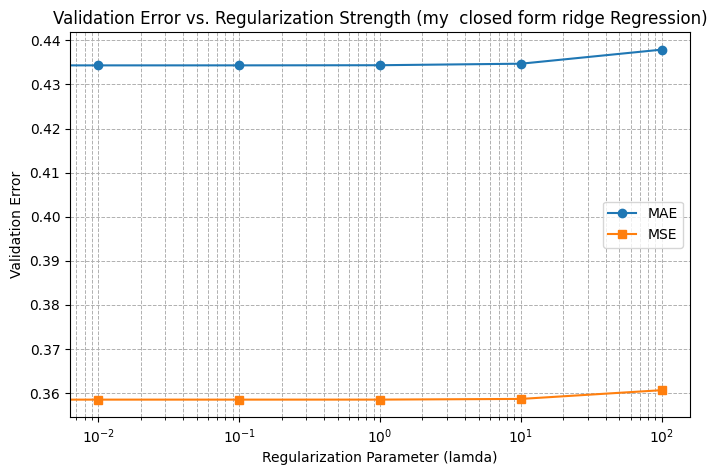

In [39]:
import matplotlib.pyplot as plt

# Sort results by lambda (important for plotting)
results_df = results_df.sort_values(by="lambda")

plt.figure(figsize=(8, 5))
plt.plot(results_df["lambda"], results_df["MAE"], marker='o', label='MAE')
plt.plot(results_df["lambda"], results_df["MSE"], marker='s', label='MSE')

plt.xscale('log') 
plt.xlabel("Regularization Parameter (lamda)")
plt.ylabel("Validation Error")
plt.title("Validation Error vs. Regularization Strength (my  closed form ridge Regression)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.show()


### sklearn closed form

In [40]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

lambda_values = [0, 0.01, 0.1, 1, 10, 100]
results = []

for lam in lambda_values:
    model = Ridge(alpha=lam, solver='auto', random_state=42)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_val_scaled)
    
    mae = mean_absolute_error(y_val, preds)
    mse = mean_squared_error(y_val, preds)
    
    results.append({
        "lambda": lam,
        "MAE": mae,
        "MSE": mse
    })

# Convert to DataFrame for easy viewing
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="MAE"))


   lambda       MAE       MSE
0    0.00  0.434325  0.358474
1    0.01  0.434326  0.358474
2    0.10  0.434329  0.358474
3    1.00  0.434359  0.358477
4   10.00  0.434704  0.358632
5  100.00  0.437900  0.360620


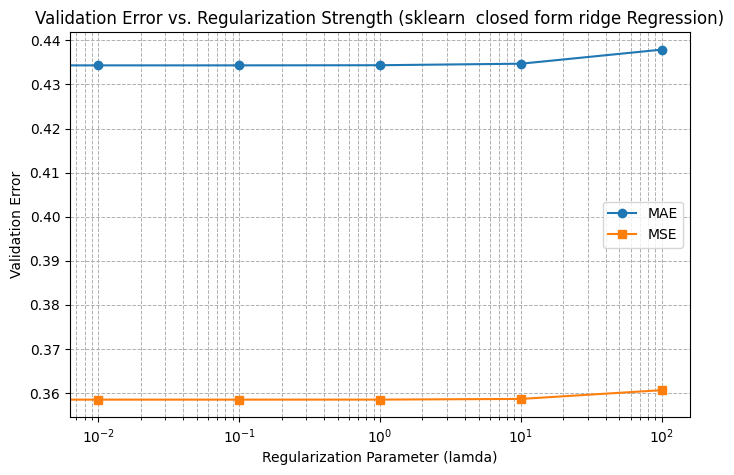

In [41]:
import matplotlib.pyplot as plt

# Sort results by lambda (important for plotting)
results_df = results_df.sort_values(by="lambda")

plt.figure(figsize=(8, 5))
plt.plot(results_df["lambda"], results_df["MAE"], marker='o', label='MAE')
plt.plot(results_df["lambda"], results_df["MSE"], marker='s', label='MSE')

plt.xscale('log') 
plt.xlabel("Regularization Parameter (lamda)")
plt.ylabel("Validation Error")
plt.title("Validation Error vs. Regularization Strength (sklearn  closed form ridge Regression)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.show()


### my lasso gd

In [42]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

lambda_values = [0, 0.01, 0.1, 1, 10, 100]
results = []

for lam in lambda_values:
    model =  linear_regression_gradient_descent_lasso(
    iterations=1000,
    learning_rate=0.1,
    lambda_param=lam  # you can tune this
)


    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_val_scaled)
    
    mae = mean_absolute_error(y_val, preds)
    mse = mean_squared_error(y_val, preds)
    
    results.append({
        "lambda": lam,
        "MAE": mae,
        "MSE": mse
    })

# Convert to DataFrame for easy viewing
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="MAE"))


   lambda       MAE       MSE
0    0.00  0.437049  0.360534
1    0.01  0.437049  0.360534
2    0.10  0.437055  0.360538
3    1.00  0.437113  0.360577
4   10.00  0.437762  0.361024
5  100.00  0.442339  0.366407


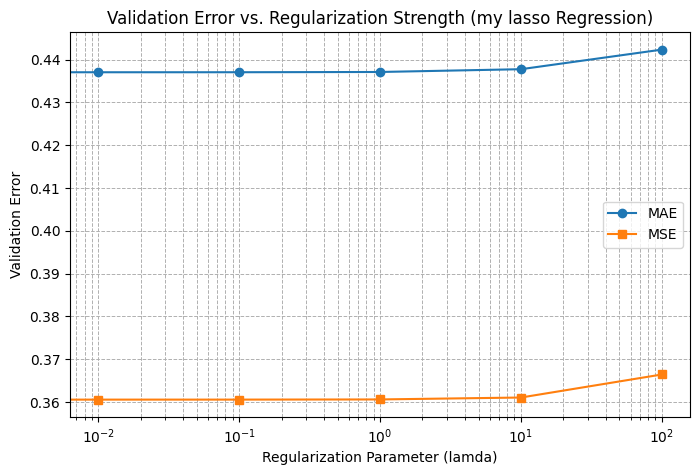

In [43]:
import matplotlib.pyplot as plt

# Sort results by lambda (important for plotting)
results_df = results_df.sort_values(by="lambda")

plt.figure(figsize=(8, 5))
plt.plot(results_df["lambda"], results_df["MAE"], marker='o', label='MAE')
plt.plot(results_df["lambda"], results_df["MSE"], marker='s', label='MSE')

plt.xscale('log') 
plt.xlabel("Regularization Parameter (lamda)")
plt.ylabel("Validation Error")
plt.title("Validation Error vs. Regularization Strength (my lasso Regression)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.show()


### sklearn lasso gd

In [44]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

lambda_values = [0, 0.01, 0.1, 1, 10, 100]
results = []

for lam in lambda_values:
    model =  SGDRegressor(
    max_iter=3000,
    tol=1e-3,
    penalty='l1',      # Lasso
    alpha=lam,         # L1 regularization strength
 
    random_state=42
)

    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_val_scaled)
    
    mae = mean_absolute_error(y_val, preds)
    mse = mean_squared_error(y_val, preds)
    
    results.append({
        "lambda": lam,
        "MAE": mae,
        "MSE": mse
    })

# Convert to DataFrame for easy viewing
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="MAE"))


   lambda       MAE       MSE
0    0.00  0.438086  0.362119
1    0.01  0.447803  0.372116
2    0.10  0.494673  0.441706
3    1.00  0.775637  0.954507
4   10.00  0.775637  0.954507
5  100.00  0.775637  0.954507


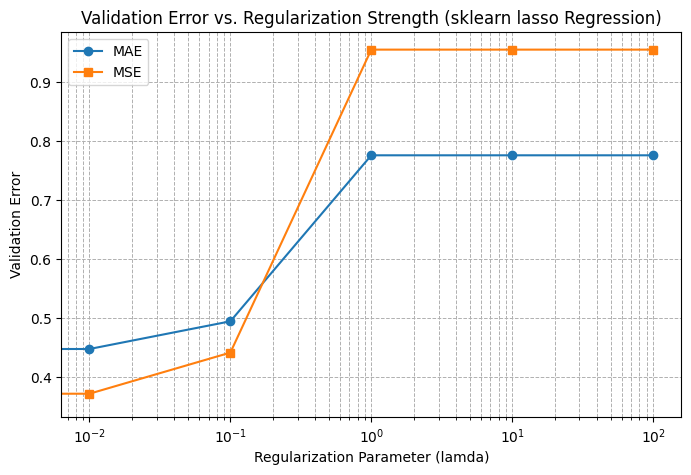

In [45]:
import matplotlib.pyplot as plt

# Sort results by lambda (important for plotting)
results_df = results_df.sort_values(by="lambda")

plt.figure(figsize=(8, 5))
plt.plot(results_df["lambda"], results_df["MAE"], marker='o', label='MAE')
plt.plot(results_df["lambda"], results_df["MSE"], marker='s', label='MSE')

plt.xscale('log') 
plt.xlabel("Regularization Parameter (lamda)")
plt.ylabel("Validation Error")
plt.title("Validation Error vs. Regularization Strength (sklearn lasso Regression)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.show()


### my ridge gd

In [46]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

lambda_values = [0, 0.01, 0.1, 1, 10, 100]
results = []

for lam in lambda_values:
    model =  linear_regression_gradient_descent_ridge(
    iterations=1000,
    learning_rate=0.1,
    lambda_param=lam
)

    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_val_scaled)
    
    mae = mean_absolute_error(y_val, preds)
    mse = mean_squared_error(y_val, preds)
    
    results.append({
        "lambda": lam,
        "MAE": mae,
        "MSE": mse
    })

# Convert to DataFrame for easy viewing
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="MAE"))


   lambda       MAE       MSE
0    0.00  0.437049  0.360534
1    0.01  0.437049  0.360534
2    0.10  0.437050  0.360535
3    1.00  0.437062  0.360541
4   10.00  0.437178  0.360601
5  100.00  0.438353  0.361397


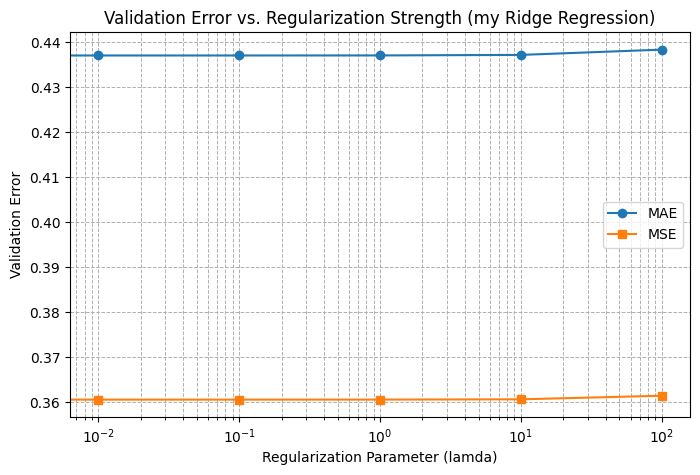

In [47]:
import matplotlib.pyplot as plt

# Sort results by lambda (important for plotting)
results_df = results_df.sort_values(by="lambda")

plt.figure(figsize=(8, 5))
plt.plot(results_df["lambda"], results_df["MAE"], marker='o', label='MAE')
plt.plot(results_df["lambda"], results_df["MSE"], marker='s', label='MSE')

plt.xscale('log') 
plt.xlabel("Regularization Parameter (lamda)")
plt.ylabel("Validation Error")
plt.title("Validation Error vs. Regularization Strength (my Ridge Regression)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.show()


### sklearn ridge gd

In [48]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

lambda_values = [0, 0.01, 0.1, 1, 10, 100]
results = []

for lam in lambda_values:
    model =   SGDRegressor(
    penalty='l2',        
    alpha=lam,          
    max_iter=1000, 
    random_state=42,
         # learning rate
)


    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_val_scaled)
    
    mae = mean_absolute_error(y_val, preds)
    mse = mean_squared_error(y_val, preds)
    
    results.append({
        "lambda": lam,
        "MAE": mae,
        "MSE": mse
    })

# Convert to DataFrame for easy viewing
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="MAE"))


   lambda       MAE       MSE
0    0.00  0.438086  0.362119
1    0.01  0.442289  0.365347
2    0.10  0.455629  0.379796
3    1.00  0.542892  0.503702
4   10.00  0.715039  0.817541
5  100.00  0.765036  0.929450


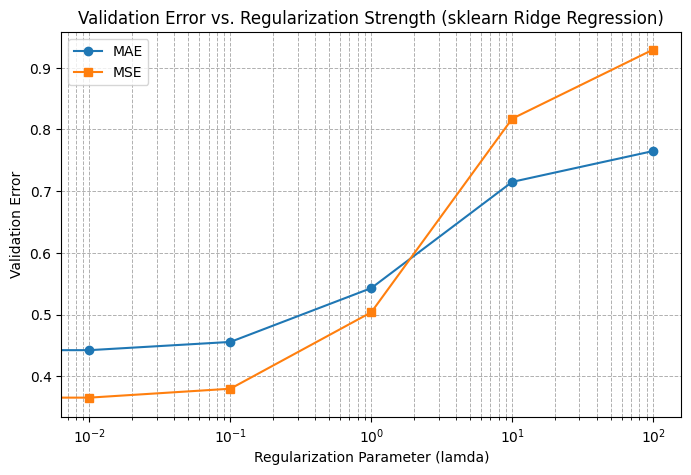

In [49]:
import matplotlib.pyplot as plt

# Sort results by lambda (important for plotting)
results_df = results_df.sort_values(by="lambda")

plt.figure(figsize=(8, 5))
plt.plot(results_df["lambda"], results_df["MAE"], marker='o', label='MAE')
plt.plot(results_df["lambda"], results_df["MSE"], marker='s', label='MSE')

plt.xscale('log') 
plt.xlabel("Regularization Parameter (lamda)")
plt.ylabel("Validation Error")
plt.title("Validation Error vs. Regularization Strength (sklearn Ridge Regression)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.show()
